In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 884.3 kB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 12.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.7/401.7 kB 121.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.9/176.9 kB 234.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2022.11.0
    Uninstalling fsspec-2022.11.0:
      Successfully uninstalled fsspec-2022.11.0


In [3]:
!pip install patchify

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [4]:
pip install lightning

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 1.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 11.6 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 13.6 MB/s eta 0:00:0000:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 22.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 24.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 25.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 34.7 MB/s eta 0:00:0000:0100:01


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 29.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 33.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 5.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 51.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 33.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 229.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.0/168.0 MB 17.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 18.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.3/802.3 kB 18.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 17.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━

In [54]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import time
import os
from patchify import patchify, unpatchify
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, random_split
import timm
import lightning as L

In [55]:
transform = transforms.Compose([transforms.Resize(384),
                                transforms.ToTensor()
                                ])

In [61]:
batch_size = 8
fake_dir = '../Sample Dataset/C23/Manipulated/DeepFake'
real_dir = '../Sample Dataset/C23/Original/Original_images'

class CustomImageDataset(Dataset):
    def __init__(self, path, transform=None):
        self.transform = transform
        self.files = [os.path.join(path, f) for f in os.listdir(path)]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file = self.files[idx]
        image = Image.open(file)
        # [Real, Fake]
        label = torch.tensor([1.0, 0.0]) if "Original" in file else torch.tensor([0.0, 1.0])
        if self.transform:
            image = self.transform(image)
        return image, label

custom_fake_dataset = CustomImageDataset(fake_dir, transform=transform)

total_samples = len(custom_fake_dataset)
train_size = 2938 #int(0.7 * total_samples)
val_size = 200 #int(0.2 * total_samples)
test_size = 100 #total_samples - train_size - val_size
rem_size =  total_samples - train_size - val_size - test_size

fake_train_subset, fake_val_subset, fake_test_subset, _ = random_split(
    custom_fake_dataset, [train_size, val_size, test_size, rem_size]
)

custom_real_dataset = CustomImageDataset(real_dir, transform=transform)

total_samples = len(custom_real_dataset)
train_size = 2938 # int(0.7 * total_samples)
val_size = 200 # int(0.2 * total_samples)
test_size = 100 # total_samples - train_size - val_size
rem_size =  total_samples - train_size - val_size - test_size

real_train_subset, real_val_subset, real_test_subset, _ = random_split(
    custom_real_dataset, [train_size, val_size, test_size, rem_size]
)

train_dataset = torch.utils.data.ConcatDataset([fake_train_subset, real_train_subset])
val_dataset = torch.utils.data.ConcatDataset([fake_val_subset, real_val_subset])
test_dataset = torch.utils.data.ConcatDataset([fake_test_subset, real_test_subset])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                             shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                             shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                             shuffle=False)

In [62]:
print("Train Loader Length", len(train_dataset))
print("Validation Loader Length", len(val_dataset))
print("Test Loader Length", len(test_dataset))

Train Loader Length 5876
Validation Loader Length 400
Test Loader Length 200


In [63]:
train_features, train_labels = next(iter(train_loader))
print(train_labels)

tensor([[1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.]])


Feature batch shape: torch.Size([8, 3, 384, 384])
Labels batch shape: torch.Size([8, 2])


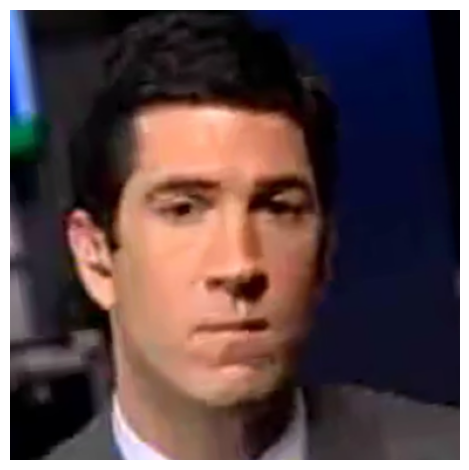

Label: tensor([1., 0.])


In [64]:
# Display image and label.
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].permute(1, 2, 0)
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.axis('off')
plt.tight_layout()
plt.show()
print(f"Label: {label}")

In [81]:
xception_weight_path = '../Weights/xception-43020ad28.pth'
# https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth
class Xception(nn.Module):
  def __init__(self):
        super(Xception, self).__init__()
        # self.xception_model = tf.keras.applications.xception.Xception(
        #     include_top=False,
        #     weights='imagenet',
        #     input_shape = (384, 384, 3)
        # )
        # self.global_avg_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.global_avg_pool = nn.AvgPool2d(12, 12)
        self.xception_model = timm.create_model('xception', pretrained=False)
        state_dict = torch.load(xception_weight_path)
        self.xception_model.load_state_dict(state_dict)
        
        # Freeze the pretrained layers
        for param in self.xception_model.parameters():
            param.requires_grad = False

  def forward(self, input):
        # x = input.permute(0, 2, 3, 1)
        # x = tf.keras.applications.xception.preprocess_input(x)
        # output = self.xception_model(x.numpy())
        # output = self.global_avg_pool(output.numpy())
        # return output.numpy()
        output = self.xception_model.forward_features(input)
        output = self.global_avg_pool(output)
        return output

In [82]:
class PatchModule(nn.Module):
  def __init__(self):
    super(PatchModule, self).__init__()
    self.conv = nn.ModuleList([
            nn.ModuleList([
                nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
                for j in range(24)
            ])
            for i in range(24)
        ])

  def extract_patches(self, img):
    patch_size = 16
    stride = 16
    patches = img.unfold(2, patch_size, stride).unfold(3, patch_size, stride)
    patches = patches.permute(2, 3, 0, 1, 4, 5).squeeze(axis=0)
    return patches

  def forward(self, x):
    patches = self.extract_patches(x)
    conv_patches = torch.zeros(24, 24, x.size(0), 3, 16, 16, device=x.device)
    for i in range(patches.shape[0]):
      for j in range(patches.shape[1]):
        for batch_idx in range(patches.shape[2]):
          conv_patches[i][j][batch_idx] = self.conv[i][j](patches[i][j][batch_idx])
    patches = patches / (torch.max(patches) + 1e-6)
    conv_patches = conv_patches / (torch.max(conv_patches) + 1e-6)
    output_image = patches * conv_patches
    output_image = output_image / (torch.max(output_image) + 1e-6)
    return output_image

In [83]:
pm = PatchModule()
outp = pm(train_features)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


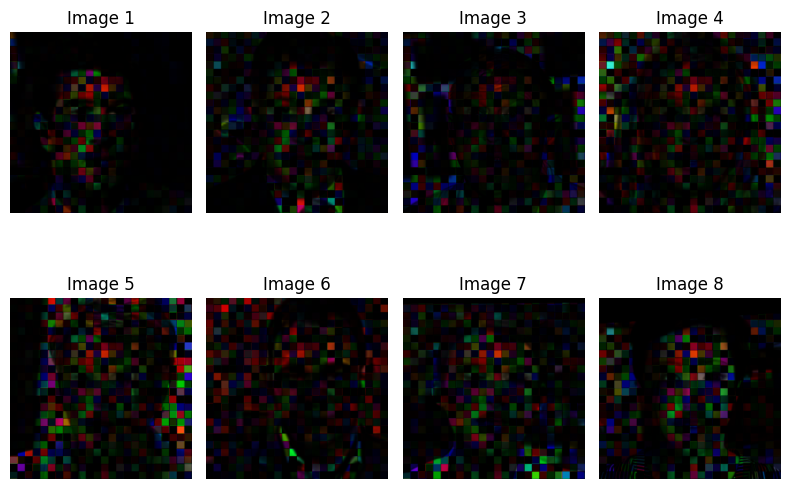

In [84]:
# Display the Self Attention Patched Images
# Permute the tensor to bring batch and channel to the front
tensor = outp.permute(2, 3, 0, 4, 1, 5)  # [batch, channel, patch_dim1, height, patch_dim2, width]

# Reshape to combine patches into full images
batch_size, channels, patch_dim1, height, patch_dim2, width = tensor.shape
combined_images = tensor.reshape(batch_size, channels, patch_dim1 * height, patch_dim2 * width)

# Display the images
def show_images(images, custom_width=2, custom_height=2):
    batch_size, channels, height, width = images.shape
    rows, cols = 2, 4  # Two rows, four columns
    fig, axes = plt.subplots(rows, cols, figsize=(8, 6))  # Set custom figure size

    for i in range(rows):
        for j in range(cols):
            img = images[i * cols + j].permute(1, 2, 0).detach().numpy()  # [C, H, W] to [H, W, C]
            axes[i, j].imshow(img)
            axes[i, j].set_title(f"Image {i * cols + j + 1}")
            axes[i, j].axis('off')

    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()

# Show the combined images
show_images(combined_images)


In [85]:
vit_weight_path = '../Weights/vit_small_patch16_384.augreg_in1k'
class VIT_Encoder(nn.Module):
  def __init__(self):
    super(VIT_Encoder, self).__init__()
    self.vit_model = timm.create_model('vit_small_patch16_384.augreg_in1k', pretrained=False)
    state_dict = torch.load(vit_weight_path)
    self.vit_model.load_state_dict(state_dict)
    
    # Freeze the pretrained layers
    for param in self.vit_model.parameters():
        param.requires_grad = False

  def forward(self, x):
    output = self.vit_model.forward_features(x)
    return output

In [86]:
class Classification_Module(nn.Module):
  def __init__(self):
    super(Classification_Module, self).__init__()
    self.model = nn.Sequential(
        nn.Linear(223616, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 2),
        nn.Softmax()
    )

  def forward(self, input):
    return self.model(input)

In [87]:
class ViXNet(nn.Module):
    def __init__(self):
      super(ViXNet, self).__init__()
      self.patch_module = PatchModule()
      self.vit_encoder = VIT_Encoder()
      self.xception = Xception()
      self.classification = Classification_Module()

    def combine_patches(self, patches):
      tensor = patches.permute(2, 3, 0, 4, 1, 5)
      batch_size, channels, patch_dim1, height, patch_dim2, width = tensor.shape
      combined_images = tensor.reshape(batch_size, channels, patch_dim1 * height, patch_dim2 * width)
      return combined_images

    def forward(self, x):
      patch_module_output = self.combine_patches(self.patch_module(x))
      vit_output = torch.flatten(self.vit_encoder(patch_module_output), 1, 2)
      xception_output = torch.flatten(self.xception(x), 1, 3)
      output = torch.cat((
          vit_output,
          xception_output
          ), dim=1)

      output = self.classification(output)
      return output

In [131]:
class LitViXNet(L.LightningModule):
    def __init__(self, vixnet):
        super().__init__()
        self.vixnet = vixnet

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self.vixnet(images)
        loss =  nn.CrossEntropyLoss()(outputs, labels)
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self.vixnet(images)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        self.log("val_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.0001)
        return optimizer

In [132]:
vixnet = ViXNet()
print(vixnet)
total_params = sum(p.numel() for p in vixnet.parameters())
print(f"Number of parameters: {total_params}")

ViXNet(
  (patch_module): PatchModule(
    (conv): ModuleList(
      (0): ModuleList(
        (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (5): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (7): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (9): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (10): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padd

In [135]:
trainable_params = sum(p.numel() for p in vixnet.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")

Number of trainable parameters: 114704770


In [136]:
model = LitViXNet(vixnet)

In [ ]:
# trainer = L.Trainer(limit_train_batches=2, max_epochs=2, devices=1)
trainer = L.Trainer(max_epochs=50)
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type   | Params
----------------------------------
0 | vixnet | ViXNet | 159 M 
----------------------------------
114 M     Trainable params
45.1 M    Non-trainable params
159 M     Total params
639.029   Total estimated model params size (MB)


Epoch 0:   4%|████▋                                                                                                           | 31/735 [00:39<15:07,  0.78it/s, v_num=7]

In [ ]:
plt.figure(figsize=(7, 7))
plt.plot(
    train_acc, color='green', linestyle='-',
    label='train accuracy'
)
plt.plot(
    valid_acc, color='blue', linestyle='-',
    label='validataion accuracy'
)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('/content/drive/MyDrive/accuracytl.png')
plt.show()
# loss plots
plt.figure(figsize=(5, 5))
plt.plot(
    train_loss, color='orange', linestyle='-',
    label='train loss'
)
plt.plot(
    valid_loss, color='red', linestyle='-',
    label='validataion loss'
)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/losstl.png')
plt.show()
# save the final model
save_path = 'model_res.pth'
torch.save(model.state_dict(), save_path)
print('MODEL SAVED...')